In [0]:
!pip install BeautifulSoup4 lxml

In [0]:
%config InlineBackend.figure_formats = ['retina']
import json
import datetime
import requests
import numpy as np
import networkx as nx
from random import sample
from urllib.parse import urlparse
from collections import deque, defaultdict
from bs4 import BeautifulSoup
from numpy import linalg as LA

In [0]:
USER_AGENT = ('Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) '
              'Apple WebKit/537.36 (KHTML, like Gecko) '
              'Chrome/80.0.3987.149 Safari/537.36')

def unique_url(url):
    """Returns a canonical representation of a link."""
    stripped = url.replace('://www.', '://')
    stripped = stripped.replace(f'{urlparse(url).scheme}://', '').rstrip('/')
    if '#' in stripped:
      # Remove trailing anchor
      return '#'.join(stripped.split('#')[:-1])
    return stripped


def check_page(url):
    """Verifies that a URL corresponds to a reachable web page."""
    try:
        head = requests.head(url,
                             headers={'User-Agent': USER_AGENT},
                             allow_redirects=True,
                             timeout=1)
        content_type = head.headers.get('Content-Type', '').lower()
        return content_type.startswith('text/html')
    except requests.exceptions.RequestException as ex:
        # Couldn't load this particular page, for whatever reason (404, etc.)
        return False


def all_links(url):
    """Retrieves all links from a web page."""
    try:
        req = requests.get(url,
                           headers={'User-Agent': USER_AGENT},
                           allow_redirects=True,
                           timeout=5)
    except requests.exceptions.RequestException as ex:
        # Couldn't load this particular page, for whatever reason (404, etc.)
        return None

    # Get links from page.
    soup = BeautifulSoup(req.text, 'lxml')
    return [link.get('href', '') for link in soup.select('a')]


def filter_links(source_url, urls, blacklist, whitelist,
                 follow_relative_links):
    """Filters and cleans links."""
    filtered = []
    o = urlparse(source_url)
    source_scheme = o.scheme
    source_domain = o.netloc

    for href in urls:
        if not href or href.startswith('#') or \
          (not href.startswith('http') and not follow_relative_links):
            # Only accept absolute links if explicitly allowed;
            # remove empty links and anchors
            continue
        else:
            if href.startswith('//'):
                href = 'https:' + href
            elif href.startswith('/'):
                # Internal link (w.r.t. website root)
                href = f'{source_scheme}://{source_domain}{href}'
            elif not href.startswith('http'):
                # Internal link (w.r.t. current link)
                href = source_url.rstrip('/') + '/' + href
        if '#' in href:
            href = '#'.join(href.split('#')[:-1]) # strip anchor

        # Blacklist/whitelist filtering.
        blacklisted = False
        whitelisted = False
        for keyword in blacklist:
            if keyword.lower() in href.lower():
                blacklisted = True
                break
        for keyword in whitelist:
            if keyword.lower() in href.lower():
                whitelisted = True
                break
        if ((whitelist and whitelisted) or not whitelist) and \
           ((blacklist and not blacklisted) or not blacklist) and \
           'mailto:' not in href and 'javascript:' not in href:
            filtered.append(href)
    return filtered


def crawl(start_url,
          save_file,
          n,
          verbose=True,
          follow_relative_links=True,
          max_links_per_page=None,
          blacklist=None,
          whitelist=None):
    """Crawls pages starting from a given URL and saves the link graph.

    :param start_url: The starting URL.
    :param save_file: The JSON file to save crawl data to.
    :param n: The number of pages to add to the graph. Pages in the graph have
        not necessarily been visited (such pages never have outlinks).
    :param verbose: Determines whether to print URLs as they are crawled.
    :param follow_relative_links: Determines whether to follow relative links.
        Following relative links tends to result in narrow, deep crawl--many
        pages being crawled on a relatively small number of websites.
    :param max_links_per_page: The number of links to add to the link queue
        per page. (For each page, the order of links is always shuffled.)
    :param blacklist: A blacklist of URL keywords. If any keyword on the
        blacklist appears in a URL, it will be excluded from the graph and
        not crawled.
    :param whitelist: A whitelist of URL keywords. If the whitelist is nonempty,
        a URL will only be included in the graph and crawled if at least one
        keyword from the whitelist is included in it. The whitelist can be
        combined with the blacklist for highly detailed URL filtering.
    """
    enqueued = set([unique_url(start_url)])
    dead = set([])
    link_graph = []
    link_queue = deque([start_url])
    ts = datetime.datetime.now().replace(microsecond=0).isoformat()
    if max_links_per_page is None:
        max_links_per_page = float('inf')
    if blacklist is None:
        blacklist = []
    if whitelist is None:
        whitelist = []

    while link_queue and len(enqueued) < n:
        # Breadth-first search: the traverse all the links on the first
        # page crawled before moving on to links on the second page crawled,
        # and so on.
        curr_link = link_queue.popleft()
        if verbose:
            print(curr_link)

        # Fetch page metadata and text
        if not check_page(curr_link):
            # Page not reachable or content type incorrect
            dead.add(curr_link)
            continue
        links = all_links(curr_link)
        if links is None:
            # GET request failed
            dead.add(curr_link)
            continue

        # Filter and sample links from the page.
        # Each filtered link has four possible states:
        # (1) Visited. (The page was loaded and its links were processed.)
        # (2) Dead. (A visit to the page was attempted but failed.)
        # (3) Enqueued. (We intend to eventually visit the page, but we have
        #                not loaded its contents yet.)
        # (4) Unseen. (A page was linked to at some point, but we have not
        #              loaded its contents and do not currently intend to.)
        # Unseen pages are retained in the link graph because we might
        # stumble across them again and decide to visit them after initially 
        # passing them over for visitation. Unseen pages that are not
        # eventually visited are filtered out of the final link graph;
        # dead pages are filtered out as well.
        # Links that pass through states (1) through (3) should be members
        # of the `enqueued` set; this way, they will not be revisited.
        filtered_links = set(filter_links(curr_link, links,
                                          blacklist, whitelist,
                                          follow_relative_links))
        new_links = [href for href in filtered_links
                     if unique_url(href) not in enqueued]
        sampled_links = sample(new_links,
                               min(max_links_per_page, len(new_links)))
        for link in filtered_links:
            link_graph.append({'from': curr_link, 'to': link})
        for link in sampled_links:
            link_queue.append(link)
            enqueued.add(unique_url(link))

    if verbose:
        print(f'Crawl finished (saw {len(enqueued)} links)')
    filtered = [link for link in link_graph
                if (unique_url(link['to']) in enqueued and 
                   link['to'] not in dead)]
    with open(save_file, 'w') as f:
        json.dump(
            {
                'start_url': start_url,
                'n': n,
                'follow_relative_links': follow_relative_links,
                'max_links_per_page': max_links_per_page,
                'timestamp': ts,
                'blacklist': blacklist,
                'whitelist': whitelist,
                'links': filtered
            }, f)

In [0]:
def load_crawl_graph(save_file):
  """Loads crawl data as a NetworkX directed graph."""
  with open(save_file) as f:
    crawl_data = json.load(f)
  graph = nx.DiGraph()
  graph.add_edges_from([(link['from'], link['to'])
                        for link in crawl_data['links']])
  for node in graph.nodes:
    graph.nodes[node]['url'] = node
  graph = nx.relabel_nodes(graph,
                           {url: idx for idx, url in enumerate(graph.nodes)})
  return graph

In [0]:
crawl('https://xkcd.com',
       'xkcd.json',  # once you run this example, you've got the output saved in this JSON format
        n=200,
        follow_relative_links=True,
        max_links_per_page=20,
        blacklist=('facebook', 'messenger', 'linkedin'))  # avoid link traps

https://xkcd.com
https://xkcd.com/newsletter/
http://pbfcomics.com/
https://xkcd.com/about
https://xkcd.com/1/
http://creativecommons.org/licenses/by-nc/2.5/
https://xkcd.com/1732/
http://www.buttercupfestival.com/
http://www.smbc-comics.com/
https://xkcd.com/rss.xml
https://xkcd.com/license.html
http://www.mspaintadventures.com/?s=6&p=001901
https://medium.com/civic-tech-thoughts-from-joshdata/so-you-want-to-reform-democracy-7f3b1ef10597
https://www.nytimes.com/interactive/2017/climate/what-is-climate-change.html
http://www.qwantz.com
Crawl finished (saw 200 links)


In [0]:
 crawl('https://en.wikipedia.org/wiki/Group_theory',
       'wiki_math.json',
        n=4000,
        follow_relative_links=True,
        max_links_per_page=20,
        whitelist=('en.wikipedia.org/wiki/',),   # this is telling it to stay within wikipedia!
        blacklist=('special:', 'talk:', 'user:', 'portal:',
                   'help:', 'category:', 'wikipedia:', 'file:'))

https://en.wikipedia.org/wiki/Group_theory
https://en.wikipedia.org/wiki/Group_action_(mathematics)
https://en.wikipedia.org/wiki/G2_(mathematics)
https://en.wikipedia.org/wiki/Theoretical_physics
https://en.wikipedia.org/wiki/Image_processing
https://en.wikipedia.org/wiki/Crystal
https://en.wikipedia.org/wiki/Number_theory
https://en.wikipedia.org/wiki/General_linear_group
https://en.wikipedia.org/wiki/Polynomial_equation
https://en.wikipedia.org/wiki/Algebraic_topology
https://en.wikipedia.org/wiki/Mark_Ronan
https://en.wikipedia.org/wiki/Integrated_Authority_File
https://en.wikipedia.org/wiki/Library_of_Congress_Control_Number
https://en.wikipedia.org/wiki/Finite_set
https://en.wikipedia.org/wiki/Algebraic_number_field
https://en.wikipedia.org/wiki/Functor
https://en.wikipedia.org/wiki/Group_of_Lie_type
https://en.wikipedia.org/wiki/Syst%C3%A8me_universitaire_de_documentation
https://en.wikipedia.org/wiki/Integer
https://en.wikipedia.org/wiki/Armand_Borel
https://en.wikipedia.org/wi

In [0]:
graph = load_crawl_graph('xkcd.json')  # or whichever JSON you want to build a graph from
A = nx.adjacency_matrix(graph).todense()

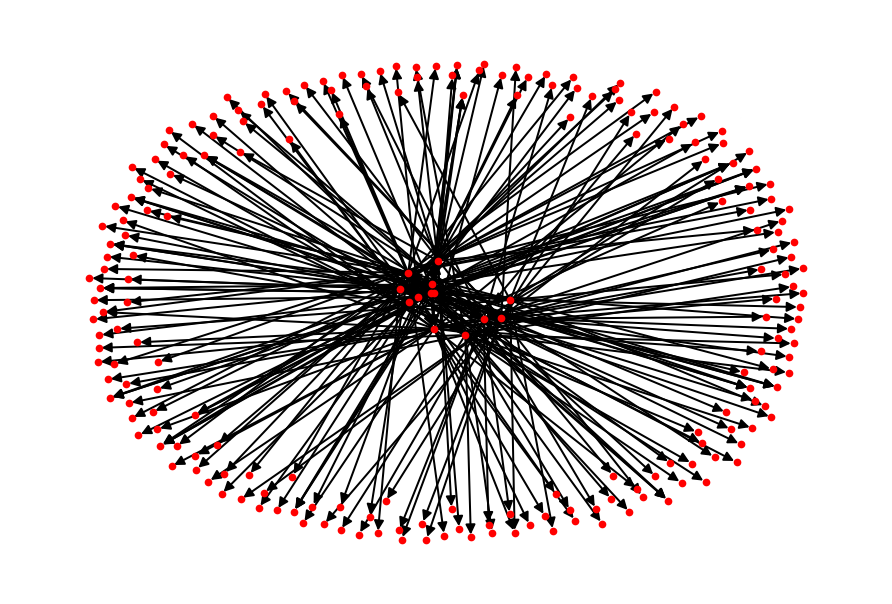

In [0]:
options = {
    'node_color': 'red',
    'node_size': 8,
}
nx.draw(graph, **options)   # there are lots of ways to visualize graphs and do graph statistics in NetworkX

In [0]:
# print(graph.nodes[0])
# print(' ')
# print(graph.nodes[0]['url'])
# print(A)

In [0]:
# Ex Code 

# Purpose: Counts one's in each row 
# Parameters: row = row in matrix, n = # of nodes 
def count_ones(row,n):
  count = 0
  for i in range(0,n):
    if np.array(row)[0][i] == 1:
      count += 1
  return count


# Purpose: Replaces one's in each row with 1/total
# Parameters: row = row in matrix, n = # of nodes, total = # of ones in row
def replace(M,row,row_count,n,total):
  # if no 1's (dead end) fill with teleportation
  if total == 0:
    for i in range(0,n):
      M[row_count][i] = (1/n)
  # if there are 1's (links)
  elif total > 0:
    for i in range(0,n):
      if np.array(row)[0][i] == 1:
        M[row_count][i] = (1/total)


# Converts Adjacency Matrix A to Transition Matrix M
# A = adjacency matrix, n = # of nodes 
def convert(A, n):
  M = np.zeros(shape = (n, n)) 
  row_count = 0
  for row in A: 
    # count # of 1's in row
    total = count_ones(row, n)
    # replace with 1's with fractions
    replace(M,row,row_count,n,total)
    # update row count 
    row_count += 1
  #return Matrix 
  return M


# Teleport - returns new matrix for given teleportation 
# M - transition matrix, prob = probability of teleportatikon
def teleport(M, prob):
  # Creates N matrix - all 1/n 
  N = np.zeros(np.shape(M))
  n = np.shape(M)[0]
  for i in range(0,n):
    for j in range(0,n):
      N[i][j] = (1/n)
  # Create P matrix 
  P = (prob * N) + ((1 - prob) * M)
  return P




# # PART 1 Transition Matrix 
# A = np.matrix([
#      #    v1     v2      v3      v4       v5
#     [     0,      1,      1,      1,      0], # v1
#     [     0,      0,      0,      0,      1], # v2
#     [     0,      1,      0,      0,      0], # v3
#     [     0,      0,      1,      0,      0], # v4
#     [     0,      0,      0,      0,      0]  # v5

# ])

# # Adjacency --> Transition
# M = convert(A, np.shape(A)[0])

# #Transition --> P
# P = teleport(M, 0.1)


# print(P)



In [0]:


# Power Method 
# P = new transition matrix, v = starting vector 
def iterate(P, v):
    converge = 0
    while converge < 301:
      init = v
      v = P.T @ init
      converge += 1
      if (np.allclose(init,v)):
        print('iteration: ', converge)
        return v




# # P = new transition matrix, v = starting vector 
# def iterate(P, v):
#     n = 0
#     while n < 301:
#       n += 1
#       a = P.T**n@v
#       b = P.T**(n+1)@v
#       if np.allclose(a,b):
#         print('iteration: ', n)
#         print(a)
#         print(' ')
#         break;

# eigenvalues 
# P - new transition matrix 
def e_values(P):
  evals, evecs = LA.eig(P.T)
  # print('eigenvalue (1):',np.round(np.real(evals[0]),6))
  sum_tot = 0
  for i in range(0,np.shape(evecs)[0]):
    sum_tot += np.round(np.real(evecs[i][0]),6)
  # returning vector for lambda = 1
  final_vec = np.zeros(shape = (1, np.shape(P)[0]))
  for i in range(0, np.shape(P)[0]):
    # retrieve first entry in each row 
    temp_num = np.round(np.real(evecs[i][0]),6)
    # normalize and store in vector 
    final_vec[0][i] = (temp_num/sum_tot)
  return final_vec

 

# max - returns index of max elements in array 
# v - vector, num - number of max elements desired 
def max_ind(v, num):
  ind = np.argpartition(v[0], np.size(v) - num)[np.size(v) - num:]
  print('index array: ', ind)
  print(' ')
  print('values', v[0][ind])
  print(' ')
  print('max value: ', max(v[0][ind]))
  print(' ')
  print(' ')
  print('URL\'s:')
  for i in range(0, np.size(ind)): 
    print(graph.nodes[ind[i]])

In [0]:
# PART 4 - different starter website - and 400 sites / nodes 
crawl('https://d23.com/disney-history/',
       'disney.json',  # once you run this example, you've got the output saved in this JSON format
        n=400,
        follow_relative_links=True,
        max_links_per_page=20,
        blacklist=('facebook', 'messenger', 'linkedin'))  # avoid link traps

https://d23.com/disney-history/
https://d23.com/d23-events-2020/
https://d23.com/list-of-disney-films/
https://privacy.thewaltdisneycompany.com/en/for-parents/childrens-online-privacy-policy/
https://d23.com/walts-quotes/
https://d23.com/disney-a-to-z/n/
https://d23.com/disney-a-to-z/g/
https://d23.com/disney-a-to-z/p/
https://d23.com/ask-dave-page/
https://preferences-mgr.truste.com/?type=disneycolor&affiliateId=115
https://disneyprivacycenter.com/
https://d23.com/news/
https://d23.com/help/
https://d23.com/redeem-gift-membership/
https://d23.com/disney-a-to-z/v/
https://d23.com/disneyplus/
https://d23.com/category/headlines/
https://d23.com/disney-a-to-z/j/
https://privacy.thewaltdisneycompany.com/en/dnsmi/
https://d23.com/disney-recipe-collection/
https://d23.com/videos-photos/
https://instagram.com/disneyd23/
https://d23.com/disney-a-to-z/h/
https://d23.com/disney-a-to-z/e/
https://d23.com/disney-a-to-z/y/
https://d23.com/category/walt-disney-archives/walt-disney-archives-exhibits/

In [0]:
graph = load_crawl_graph('disney.json')  # or whichever JSON you want to build a graph from
A = nx.adjacency_matrix(graph).todense() # number of linkes = # of nodes 


# Actual Work 


print('Matrix Dimensions: ',np.shape(A))



# REAL OUTPUT 
# A - adjacency matrix, prob - probability of transportation
def real_output(A,prob):

  # Adjacency --> Transition
  M = convert(A,np.shape(A)[0])
  # Transiiton --> P
  P = teleport(M, prob)

  # start position 
  v = np.zeros(shape = (np.shape(A)[0],1))
  v[0][0] = 1

  # get stationary vector - power method 
  print('POWER METHOD ')
  final_v = iterate(P,v)

  # retrieve top 10 values 
  max_ind(final_v.T, 10)

  print(' ')
  print(' ')
  # get stationary vector - eigenvalue 
  print('EIGEN-LA METHOD ')
  second_final = e_values(P)

  # retrieve top 10 values 
  max_ind(second_final, 10)









print(' PROB = 0.1')
real_output(A, 0.1)

print(' ')
print(' ')
print('PROB = 0.2')
real_output(A, 0.2)

print(' ')
print(' ')
print('PROB = 0.3')
real_output(A, 0.3)

print(' ')
print(' ')
print('PROB = 0.4')
real_output(A, 0.4)

print(' ')
print(' ')
print('PROB = 0.5')
real_output(A, 0.5)

print(' ')
print(' ')
print('PROB = 0.6')
real_output(A, 0.6)

print(' ')
print(' ')
print('PROB = 0.7')
real_output(A, 0.7)

print(' ')
print(' ')
print('PROB = 0.8')
real_output(A, 0.8)

print(' ')
print(' ')
print('PROB = 0.9')
real_output(A, 0.9)

print(' ')
print(' ')
print('PROB = 1.0')
real_output(A, 1.0)


## SOLUTION - DO TOMORROW -- if rows in A are all 0 --> replace entries with 1/n --> directed graph problem - teleportation issue (p - teleportation?? )

# --> count #'s of 1 in each row (n) . Replace entries (1) in old matrix with (1/n) in new matrix -> M.      P = M.T
# --> Start with any point --> Power Method until Pw = w OR eigenvalue (lambda = 1)

# FLAWS --> It shows importance purely based on theory - clicking any random link (assumes that each link on a page is 
# clicked an equal amount of times. However some buttons are bigger than others - also a link to 
# a sign in page will likely be clicked on more than a tiny link to cusomter service at the bery bottom 
# of the page. There are a lot of behaviors and user design variations that alter foot traffick in terms 
# of which links are clicked --> How to design (Utilize real data of # of clicks in each page (and which 
# links they clicked on --> weight as probabilities instead of evenly dividing links)))



# 0.1 -->  0.0028895977287200967
# 0.2 -->  0.00282569402465651
# 0.3 -->  0.002764451703737672
# 0.4 -->  0.0027056872080935927
# 0.5 -->  0.002649272906295727
# 0.6 -->  0.0025950790146423756
# 0.7 -->  0.0025430087761654486
# 0.8 -->  0.0024928641665273896
# 0.9 -->  0.0024446071309480776
# 1.0 -->  0.0023980815347721656

Matrix Dimensions:  (422, 422)
 PROB = 0.1
POWER METHOD 
iteration:  9
index array:  [128 130   8 129  74 122 121 120  45  65]
 
values [0.00283664 0.00283664 0.00338773 0.00283664 0.00338773 0.00283664
 0.00283664 0.00283664 0.00338773 0.00306319]
 
max value:  0.0033877303581069168
 
 
URL's:
{'url': 'https://privacy.thewaltdisneycompany.com/en/for-parents/'}
{'url': 'https://privacy.thewaltdisneycompany.com/en/current-privacy-policy/your-california-privacy-rights/'}
{'url': 'https://disneytermsofuse.com/'}
{'url': 'https://privacy.thewaltdisneycompany.com/en/'}
{'url': 'https://privacy.thewaltdisneycompany.com/en/dnsmi/'}
{'url': 'https://privacy.thewaltdisneycompany.com/en/privacy-controls/'}
{'url': 'https://privacy.thewaltdisneycompany.com/en/support/'}
{'url': 'https://privacy.thewaltdisneycompany.com/en/privacy-controls/communication-choices/'}
{'url': 'https://privacy.thewaltdisneycompany.com/en/for-parents/childrens-online-privacy-policy/'}
{'url': 'https://disneyprivacycente

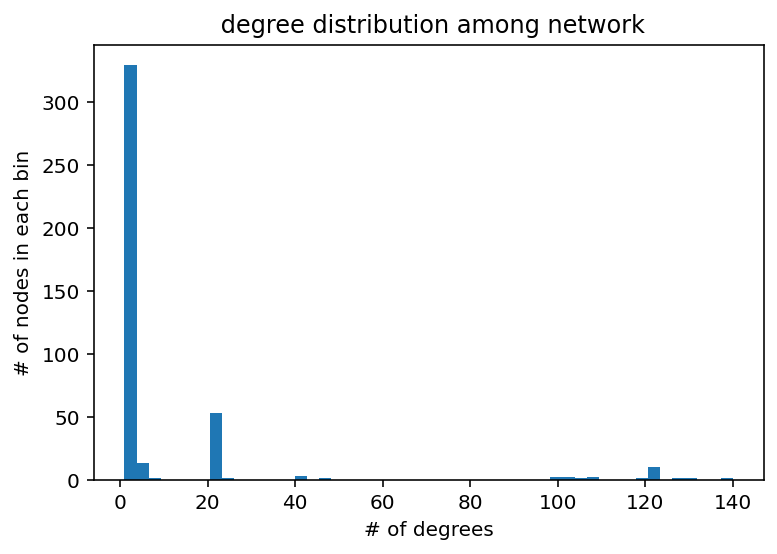

In [0]:
options = {
    'node_color': 'blue',
    'node_size': 8,
}
# nx.draw(graph, **options)   # there are lots of ways to visualize graphs and do graph statistics in NetworkX

import matplotlib.pyplot as plt

def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, bins = 50)
    plt.xlabel('# of degrees')
    plt.ylabel('# of nodes in each bin')
    plt.title(' degree distribution among network')
    plt.show()


plot_degree_dist(graph)



In [0]:
a = np.array([[5,6,9,1,3,4,6,7,4,4]])

print(max(a[0]))

NameError: ignored